In [252]:
from csv import reader
import sqlite3
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

In [253]:
# ============================================================================================================
# db connection and close functions
# ============================================================================================================

def connect_to_db(dbName):
    try:
        # establish a connection OR create new db and connect
        # dbconn is an object that will facilitate our communication to db
        dbconn = sqlite3.connect(dbName)
        #ask the connection for an object called a cursor
        cursor = dbconn.cursor()
        print('Connected to DB!')
    except sqlite3.Error as err:
        print("Error connecting")
        print(err)
    return dbconn,cursor
# ============================================================================================================
def close_DB_Resources(dbconn, cursor):
    '''
    Came directly from Lisa's guide
    https://github.com/lan33-ccac/DAT-129/blob/e05c8244077a518778df7457879f39d50e564fb8/DB_Interaction/dbdemo2.py#L332
    '''
    try:
        cursor.close()
        dbconn.close()
        print('\nDB resources were closed successfully.')
    except sqlite3.Error as error:
        print('Error occurred closing DB resources.', error)

In [254]:
# ============================================================================================================
# db create, load and drop tables functions
# ============================================================================================================

def create_tables():
    
# --------------------------------------------------------
#  genders 
# --------------------------------------------------------
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS
            genders (
                genderID INTEGER PRIMARY KEY,
                genderCode TEXT NOT NULL,
                genderName TEXT NOT NULL,
        UNIQUE (genderCode, genderName) ON CONFLICT IGNORE
            );        
    ''')
    print('genders table created.')
# --------------------------------------------------------
#  names   
# --------------------------------------------------------
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS
            names (
                nameID INTEGER PRIMARY KEY,
                name TEXT NOT NULL,
        UNIQUE (name) ON CONFLICT IGNORE
            );
    ''')
    print('names table created.')
# --------------------------------------------------------    
# ssaNamesData
# --------------------------------------------------------
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS
            ssaNameData (
                year INT NOT NULL,
                nameID INT NOT NULL,
                genderID INT NOT NULL,
                number INT NOT NULL
            );
    ''')
    print('ssaNameData table created.')
# --------------------------------------------------------
    dbconn.commit()
    
# UNIQUE prevents duplicate data in the column, 
# it does not look at the combination of columns
# therefore I was not able to use it in the ssaNameData table
# ============================================================================================================

def drop_table(tblName):
    
    dropTable = 'DROP TABLE IF EXISTS '+ tblName
    cursor.execute(dropTable)
    print('Table',tblName,'was deleted.')
    dbconn.commit()
# ============================================================================================================

def load_genders_table():
    
    genders_list = [('F', 'Female'),('M', 'Male')]

    # insert gender data into the table
    gender_insert = '''
        INSERT INTO genders (genderCode, genderName)
        VALUES (?, ?);
    '''

    # for each gender in the gender list
    # create a code, name tuple
    for g in genders_list:
        insert_tuple = (g[0],g[1])
        cursor.execute(gender_insert, insert_tuple)
        print(insert_tuple, 'loaded to genders table')
    dbconn.commit()
# ============================================================================================================

def load_names_table(root):
    
    # insert names data into the table
    name_insert = '''
        INSERT INTO names (name)
        VALUES (?);
    '''
    for location, directories, files in os.walk(root):
        # for each file in the folder
        for file in files:
            filename = location + str(os.sep) + file
            print('reading names from: ', filename)
            count = 0
            # open and read the file
            with open (filename) as ssafile:
                csv_reader = reader(ssafile)
                # for each row in the file
                for row in csv_reader:
                    # find name in the record and insert 
                    cursor.execute(name_insert,(row[0],))
                    count +=1    # keep a count of records found
            print('names found: ', count)

    dbconn.commit()
# ============================================================================================================

def getID(SELECT, match):
    # function to run the select query passed through SELECT and return the ID for match
    cursor.execute(SELECT,(match,))
    foundID = cursor.fetchone()
    return foundID[0]
# ============================================================================================================
def load_ssaNameData_table(root):
    # build the sql INSERT statement
    ssaNameData_insert = '''
        INSERT INTO ssaNameData (year, nameID, genderID, number)
        VALUES (?, ?, ?, ?);
    '''
    # These are select queries to pass in to getID() and return the matching name/gender id
    getnameID = 'SELECT nameID, name FROM names WHERE name=?' 
    getgenderID = 'SELECT genderID, genderCode FROM genders WHERE genderCode=?' 

    # for each file in the directory open and retrieve ssaNameData per row
    for location, directories, files in os.walk(root):
        for file in files:
            filename = location + str(os.sep) + file 
            print('loading data from: ', filename)
            count = 0    # start record count
            year = int(re.findall(r'\d+', file)[0])    # get year from file name to load as year

            with open (filename) as ssafile:
                csv_reader = reader(ssafile)
                # for each row, get data for insert_tuple
                for row in csv_reader:
                    nameID = getID(getnameID, row[0])    # finds nameID from names table
                    genderID = getID(getgenderID, row[1])    # finds genderID from gender table
                    number = int(row[2])    # finds the data value for name occurences
                    insert_tuple = (year, nameID, genderID, number)    #creates tuple of row data        
                    cursor.execute(ssaNameData_insert,insert_tuple)    # inserts data from tuple into data table
                    count +=1    # counts the number of rows found
            print('\trecords found: ', count)

    dbconn.commit()
    
# === Room for improvement ===
# This function loads all files in the folder
# if a new file is recevied all data should be
# deleted and reloaded to avoid duplication.

In [255]:
# ============================================================================================================
# data queries
# ============================================================================================================

def qry1(namesList):

    # This query sums the occurences for each name per year (regardless of gender)
    
    inList = str(namesList)[1:-1]

    selectFrom='''
         SELECT names.name, ssaNameData.year, sum (ssaNameData.number) AS 'occurences'
            FROM ssaNameData INNER JOIN names on ssaNameData.nameID = names.nameID
            '''
    where= 'WHERE names.name IN'
    groupOrder='''
            GROUP BY names.name, ssaNameData.year
            ORDER BY ssaNameData.year DESC, names.name;
    '''
    if inList.lower() == str(['all'])[1:-1]:
        qrySQL = (selectFrom + groupOrder)
    else:
        qrySQL = (selectFrom + where + ' ('+ inList + ') '+ groupOrder)
        
    return qrySQL
# ============================================================================================================
def qry2(namesList):
    
    # This query shows per name, first/last year appeared and year of peak occurences
    
    inList = str(namesList)[1:-1]

    selectFrom='''
        SELECT t1.name, t1.first, t2.peakYear, t1.last
        FROM
            (SELECT names.name, min(ssaNameData.year) as 'first', max(ssaNameData.year) AS 'last'
            FROM ssaNameData INNER JOIN names on ssaNameData.nameID = names.nameID
            GROUP BY names.name
            ORDER BY name) t1
        LEFT JOIN
            (SELECT names.name, ssaNameData.year AS 'peakYear', max(ssaNameData.number) AS 'peakOccur' 
            FROM ssaNameData INNER JOIN names on ssaNameData.nameID = names.nameID
            GROUP BY names.name) t2
            ON (t1.name = t2.name)
            '''
    where='WHERE t1.name IN'

    if inList.lower() == str(['all'])[1:-1]:
        qrySQL = (selectFrom + ';')
    else:
        qrySQL = (selectFrom + where + ' (' + inList + ');')

    return qrySQL
# ============================================================================================================
def qry3(namesList):
    
    # This query shows per name, total occurences descending 
    
    inList = str(namesList)[1:-1]

    selectFrom='''
        SELECT names.name, sum (ssaNameData.number) AS 'occurences'
            FROM ssaNameData INNER JOIN names on ssaNameData.nameID = names.nameID
            '''
    where= 'WHERE names.name IN'
    groupOrder='''
            GROUP BY names.name
            ORDER BY occurences DESC;
            '''
    if inList.lower() == str(['all'])[1:-1]:
        qrySQL = (selectFrom + groupOrder)
    else:
        qrySQL = (selectFrom + where + ' ('+ inList + ') '+ groupOrder)

    return qrySQL 
# ============================================================================================================
def qry4(namesList):
    
    # This query shows per name the count of years ranked #1 in most occurences
    
    qrySQL='''
        SELECT t1.name, t1.genderName as 'gender', count(t1.year) as 'yearsTopRank'
        FROM
            (SELECT ssaNameData.year, names.name,genders.genderName, max(ssaNameData.number) as 'occurences'
                FROM ssaNameData INNER JOIN names on ssaNameData.nameID = names.nameID
                INNER JOIN genders on ssaNameData.genderID = genders.genderID
                GROUP BY ssaNameData.year, genders.genderName) as t1
        GROUP BY t1.name
        ORDER BY [yearsTopRank] DESC
        '''
    return qrySQL
# ============================================================================================================
def qry5(namesList):

    # This query shows per gender the count of unique names and total occurences
    
    qrySQL='''
        SELECT genders.genderName as 'gender', COUNT(DISTINCT names.name) AS 'uniqueNames',
            SUM(ssaNameData.number) AS 'Occurences'
        FROM ssaNameData INNER JOIN names on ssaNameData.nameID = names.nameID
        INNER JOIN genders on ssaNameData.genderID = genders.genderID
        GROUP BY gender
        '''
    return qrySQL
# ============================================================================================================
def qry6(namesList):
    
    # This query shows the count of unique names and total occurences
    
    qrySQL='''
        SELECT COUNT(DISTINCT names.name) AS 'uniqueNames', SUM(ssaNameData.number) AS 'occurences'
        FROM ssaNameData INNER JOIN names on ssaNameData.nameID = names.nameID
        '''
    return qrySQL
# ============================================================================================================
def qry7(namesList):

    # This query show the Top name per gender per year
    
    qrySQL='''
        SELECT ssaNameData.year, names.name,genders.genderName as 'gender', max(ssaNameData.number) as 'num'
        FROM ssaNameData INNER JOIN names on ssaNameData.nameID = names.nameID
        INNER JOIN genders on ssaNameData.genderID = genders.genderID
        GROUP BY ssaNameData.year, gender
        ORDER BY ssaNameData.year DESC, gender
        '''
    return qrySQL

In [256]:
# ===================
# pandas data frames
# ===================

def qry_table(query, namesList,topN=25):
# display query as data table
    df = pd.read_sql_query(query(namesList), dbconn).head(topN)
    display(df)
    
def qry1_pivotTable(query, namesList):
    # display query 1 as data table (Head counts per year)
    df = pd.read_sql_query(query(namesList), dbconn).pivot('year', 'name', 'occurences').sort_index(ascending=False).fillna(0).style.format('{:20,.0f}').set_caption('Occurences by year and name - Details')
    display(df)
    # === TO DO ===
    # sort year desc
        
def qry1_graph(query, namesList):
    # display query 1 as graph (Head counts per year)
    df = pd.read_sql_query(query(namesList), dbconn).pivot('year', 'name', 'occurences')
    plt.figure(figsize=(15,10)); df.plot(colormap='jet'); plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
    plt.title('Occurences by year and name - Graph')

In [257]:
# ===========================================
# program actions for future menu navigation
# ===========================================

def action(action=0):
    
    if action == 1:    # initionalize db and create tables for gender, name, and data
        create_tables()

    elif action == 2:    # load unique genders into the gender table
        load_genders_table()
 
    elif action == 3:    # load from data files, unique names into the names table
        load_names_table(filesLoc)

    elif action == 4:    # load from data files, unique names into the names table
        load_ssaNameData_table(filesLoc)

    elif action == 5:    # drop 'ssaNameData' to reload data
        drop_table('ssaNameData')

    elif action == 6:    # drop 'names' to reload data
        drop_table('names') 
        
    elif action == 7:    # drop 'genders' to reload data
        drop_table('genders')

In [258]:
# ===========================================
# various name lists for queries
# ===========================================

def qryNames(listNumber):

    if listNumber == 0:
        listNames = ['All']

    elif listNumber == 1:    # Top Ranked Names each year
        listNames = ['Mary', 'Michael', 'John','Robert', 'Jennifer', 'Jacob', 'James',
                     'Emily', 'Jessica', 'Lisa', 'Linda', 'Emma', 'Noah', 'Sophia',
                     'Liam', 'Isabella', 'Ashley', 'Olivia', 'David']

    elif listNumber == 2:    # Top 5 overall
        listNames = ['James', 'John','Robert', 'Michael',  'William']

    elif listNumber == 3:    # Bottom 5 overall among Top Ranked Names
        listNames = ['Noah', 'Sophia', 'Liam', 'Isabella', 'Olivia',]


    elif listNumber == 4:    # Class Names - SP21 Python 2 6pm W
        listNames = ['Eric', 'Loretta', 'Virginia', 'Shane', 'Kamala', 'Evan', 'Jon',
                       'Leon', 'Rachael', 'Katie', 'Alissa', 'Matthew', 'Timothy',
                       'Carl', 'Alev', 'Ian', 'Monica', 'Paige']
        
    elif listNumber == 5:    # Class Names - Presentation Group - to be updated in class after group assignment
        listNames = ['Eric','Loretta', 'Alissa','Virginia', 'Shane', 'Kamala', 'Evan', 'Jon',
                       'Leon', 'Rachael', 'Katie', 'Alissa', 'Matthew', 'Timothy',
                       'Carl', 'Alev', 'Ian', 'Monica', 'Paige']

    elif listNumber == 6:    # Top 5 Class Names
        
        listNames = ['Matthew', 'Timothy', 'Carl','Eric', 'Virginia']

    elif listNumber == 7:    # Spelling Variations
        
        listNames = ['Alyssa', 'Alissa']

    elif listNumber == 8:    # select names
        listNames = ['Adolf']

    return listNames

In [259]:
# ===============================================
# === FINAL PROJECT - SP21 DAT129 - Python II ===
# ===============================================
# source data downloaded in a zip file from 
# https://www.ssa.gov/oact/babynames/limits.html
# ===============================================

In [263]:
# ==================================
# define location and database name
# ==================================

# define location of data files:
filesLoc = '.\ssaNames_national\data'

# define name of database:
dbName = 'fp_SSAnames.db'

# ==================================
# run database table actions
# ==================================

dbconn,cursor = connect_to_db(dbName)

action(0)

close_DB_Resources(dbconn, cursor)

# ACTION definitions
# ===========================================================
# 0: no action runs

# 1: create tables for genders, names, and data
# 2: load unique GENDERS into the 'genders' table
# 3: load unique NAMES from files into the 'names' table
# 4: load DATA from files into the 'ssaNames_National' table

# 5: drop 'ssaNameData' to reload data
# 6: drop 'genders' table to reload table
# 7: drop 'names' table to reload table
# ===========================================================

# ========== Room for Improvement ==========
# add error handling if files don't exist


Connected to DB!
genders table created.
names table created.
ssaNameData table created.
('F', 'Female') loaded to genders table
('M', 'Male') loaded to genders table
reading names from:  .\ssaNames_national\data\yob1880.txt
names found:  2000
reading names from:  .\ssaNames_national\data\yob1881.txt
names found:  1935
reading names from:  .\ssaNames_national\data\yob1882.txt
names found:  2127
reading names from:  .\ssaNames_national\data\yob1883.txt
names found:  2084
reading names from:  .\ssaNames_national\data\yob1884.txt
names found:  2297
reading names from:  .\ssaNames_national\data\yob1885.txt
names found:  2294
reading names from:  .\ssaNames_national\data\yob1886.txt
names found:  2392
reading names from:  .\ssaNames_national\data\yob1887.txt
names found:  2373
reading names from:  .\ssaNames_national\data\yob1888.txt
names found:  2651
reading names from:  .\ssaNames_national\data\yob1889.txt
names found:  2590
reading names from:  .\ssaNames_national\data\yob1890.txt
names 

names found:  19509
reading names from:  .\ssaNames_national\data\yob1985.txt
names found:  20086
reading names from:  .\ssaNames_national\data\yob1986.txt
names found:  20657
reading names from:  .\ssaNames_national\data\yob1987.txt
names found:  21409
reading names from:  .\ssaNames_national\data\yob1988.txt
names found:  22369
reading names from:  .\ssaNames_national\data\yob1989.txt
names found:  23775
reading names from:  .\ssaNames_national\data\yob1990.txt
names found:  24716
reading names from:  .\ssaNames_national\data\yob1991.txt
names found:  25114
reading names from:  .\ssaNames_national\data\yob1992.txt
names found:  25426
reading names from:  .\ssaNames_national\data\yob1993.txt
names found:  25965
reading names from:  .\ssaNames_national\data\yob1994.txt
names found:  25997
reading names from:  .\ssaNames_national\data\yob1995.txt
names found:  26079
reading names from:  .\ssaNames_national\data\yob1996.txt
names found:  26423
reading names from:  .\ssaNames_national\dat

	records found:  10305
loading data from:  .\ssaNames_national\data\yob1951.txt
	records found:  10463
loading data from:  .\ssaNames_national\data\yob1952.txt
	records found:  10645
loading data from:  .\ssaNames_national\data\yob1953.txt
	records found:  10837
loading data from:  .\ssaNames_national\data\yob1954.txt
	records found:  10981
loading data from:  .\ssaNames_national\data\yob1955.txt
	records found:  11122
loading data from:  .\ssaNames_national\data\yob1956.txt
	records found:  11339
loading data from:  .\ssaNames_national\data\yob1957.txt
	records found:  11568
loading data from:  .\ssaNames_national\data\yob1958.txt
	records found:  11526
loading data from:  .\ssaNames_national\data\yob1959.txt
	records found:  11768
loading data from:  .\ssaNames_national\data\yob1960.txt
	records found:  11925
loading data from:  .\ssaNames_national\data\yob1961.txt
	records found:  12180
loading data from:  .\ssaNames_national\data\yob1962.txt
	records found:  12211
loading data from

In [264]:
# ==========================================================
# run data queries for overall data
# ==========================================================
# queries have a top 25 rows limit, and an optional argument
# to increase or decrease the number of rows displayed.

In [265]:
dbconn,cursor = connect_to_db(dbName)
print('\nOverall')
qry_table(qry6,['All'])
close_DB_Resources(dbconn, cursor)

Connected to DB!

Overall


,uniqueNames,occurences
0,99444,355149899



DB resources were closed successfully.


In [266]:
dbconn,cursor = connect_to_db(dbName)
print('\nOverall by gender')
qry_table(qry5,['All'])
close_DB_Resources(dbconn, cursor)

Connected to DB!

Overall by gender


,gender,uniqueNames,Occurences
0,Female,68332,175768302
1,Male,42054,179381597



DB resources were closed successfully.


In [267]:
dbconn,cursor = connect_to_db(dbName)
print('\nNumber of years ranked #1 in occurences')
print('by name and gender')
qry_table(qry4,['All'])
close_DB_Resources(dbconn, cursor)

Connected to DB!

Number of years ranked #1 in occurences
by name and gender


,name,gender,yearsTopRank
0,Mary,Female,76
1,Michael,Male,44
2,John,Male,44
3,Robert,Male,17
4,Jennifer,Female,15
5,Jacob,Male,14
6,James,Male,13
7,Emily,Female,12
8,Jessica,Female,9
9,Lisa,Female,8



DB resources were closed successfully.


In [268]:
dbconn,cursor = connect_to_db(dbName)
print('\nTotal occurences by name')
qry_table(qry3,['All'],10)
close_DB_Resources(dbconn, cursor)

Connected to DB!

Total occurences by name


,name,occurences
0,James,5201182
1,John,5155617
2,Robert,4845266
3,Michael,4395357
4,William,4147152
5,Mary,4143217
6,David,3643465
7,Joseph,2633323
8,Richard,2576936
9,Charles,2411726



DB resources were closed successfully.


In [269]:
dbconn,cursor = connect_to_db(dbName)
print('\nTotal occurences by name and gender')
qry_table(qry7,['All'],10)
close_DB_Resources(dbconn, cursor)

Connected to DB!

Total occurences by name and gender


,year,name,gender,num
0,2019,Olivia,Female,18451
1,2019,Liam,Male,20502
2,2018,Emma,Female,18757
3,2018,Liam,Male,19915
4,2017,Emma,Female,19830
5,2017,Liam,Male,18821
6,2016,Emma,Female,19517
7,2016,Noah,Male,19144
8,2015,Emma,Female,20463
9,2015,Noah,Male,19646



DB resources were closed successfully.


In [270]:
# =====================================
# run data queries for selected name/s
# =====================================

selectNames = qryNames(5)

# === Query Names Lists ===
# ============================================
# 0: All
# 1: Top Names each year
# 2: Top Names overall
# 3: Bottom 5 overall among Top Ranked Names
# 4: Class Names - SP21 Python 2 6pm W
# 5: Top 5 Class Names
# 6: Spelling Variations
# 7: Other select name(s)
# ============================================

In [271]:
dbconn,cursor = connect_to_db(dbName)
print('\nTotal occurences by year and name')
qry_table(qry1, selectNames)
close_DB_Resources(dbconn, cursor)

Connected to DB!

Total occurences by year and name


,name,year,occurences
0,Alissa,2019,151
1,Carl,2019,314
2,Eric,2019,2187
3,Evan,2019,4016
4,Ian,2019,4532
5,Jon,2019,312
6,Kamala,2019,13
7,Katie,2019,674
8,Leon,2019,1853
9,Loretta,2019,252



DB resources were closed successfully.


In [272]:
dbconn,cursor = connect_to_db(dbName)
print('\nTotal occurences by name')
qry_table(qry3, selectNames)
close_DB_Resources(dbconn, cursor)

Connected to DB!

Total occurences by name


,name,occurences
0,Matthew,1615435
1,Timothy,1077401
2,Eric,883684
3,Virginia,651576
4,Carl,506591
5,Evan,274883
6,Monica,249856
7,Katie,238210
8,Ian,232268
9,Shane,192891



DB resources were closed successfully.


In [273]:
dbconn,cursor = connect_to_db(dbName)
print('\nFirst and last year in data')
print('and year of peak occurence')
qry_table(qry2, selectNames)
close_DB_Resources(dbconn, cursor)

Connected to DB!

First and last year in data
and year of peak occurence


,name,first,peakYear,last
0,Alissa,1948,1998,2019
1,Carl,1880,1956,2019
2,Eric,1880,1970,2019
3,Evan,1880,2007,2019
4,Ian,1912,2005,2019
5,Jon,1898,1964,2019
6,Kamala,1955,1964,2019
7,Katie,1880,1986,2019
8,Leon,1880,1924,2019
9,Loretta,1880,1938,2019



DB resources were closed successfully.


Connected to DB!

DB resources were closed successfully.


<Figure size 1080x720 with 0 Axes>

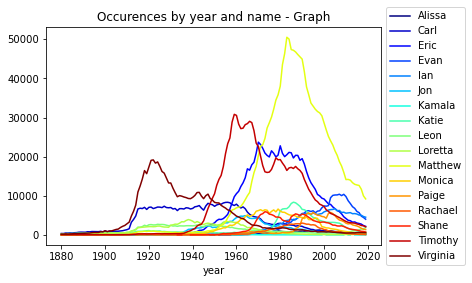

In [274]:
dbconn,cursor = connect_to_db(dbName)
qry1_graph(qry1, selectNames)
close_DB_Resources(dbconn, cursor)

In [275]:
dbconn,cursor = connect_to_db(dbName)
qry1_pivotTable(qry1, selectNames)
close_DB_Resources(dbconn, cursor)

Connected to DB!


name,Alissa,Carl,Eric,Evan,Ian,Jon,Kamala,Katie,Leon,Loretta,Matthew,Monica,Paige,Rachael,Shane,Timothy,Virginia
year,,,,,,,,,,,,,,,,,
2019,151,314,"2,187","4,016","4,532",312,13,674,"1,853",252,"9,214",453,"1,364",80,738,"2,069",567
2018,202,343,"2,398","4,467","4,703",311,10,716,"1,599",231,"9,983",498,"1,450",114,887,"2,341",583
2017,224,413,"2,766","4,809","5,034",319,10,778,"1,511",229,"11,699",472,"1,699",116,932,"2,411",611
2016,224,443,"2,928","5,694","5,085",355,10,898,"1,309",240,"12,648",521,"2,050",162,"1,083","2,668",603
2015,289,457,"3,046","6,009","5,340",330,9,"1,056","1,138",217,"12,775",556,"2,291",185,"1,231","2,801",599
2014,322,435,"3,323","6,795","5,463",376,10,"1,167","1,078",179,"12,938",577,"2,418",210,"1,312","3,010",523
2013,375,445,"3,273","7,221","5,428",386,0,"1,324","1,016",119,"13,358",597,"2,574",244,"1,405","3,058",539
2012,416,486,"3,633","8,025","5,702",388,8,"1,448",859,122,"13,999",722,"2,913",295,"1,493","3,118",507
2011,474,426,"3,748","8,753","5,632",346,7,"1,668",694,110,"14,193",779,"2,814",321,"1,664","3,232",507



DB resources were closed successfully.
